Import library

In [86]:
import torch
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image

Split Dataset and data loader 

In [113]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load the dataset
dataset = datasets.ImageFolder(root='Dataset', transform=transform)
total_size = len(dataset)
val_size = int(0.1 * total_size)  
train_size = total_size - val_size 

# Split the dataset
train_data, val_data = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

Visualize the data

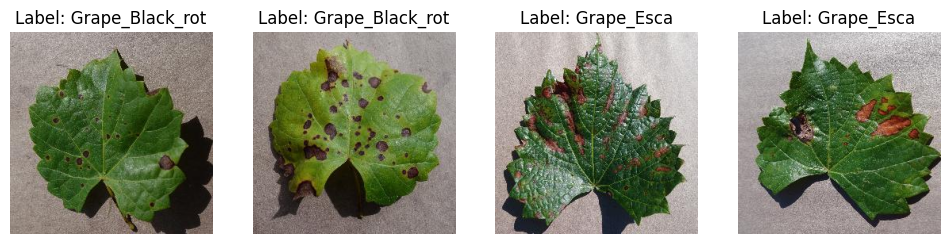

In [118]:
images, labels = next(iter(train_loader))

# Display a few images with class names as labels
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    ax = axes[i]
    img = images[i].permute(1, 2, 0).numpy()  # Change the order of dimensions from (C, H, W) to (H, W, C) and convert to numpy array
    #img = img / img.max()  # Normalize the image to [0, 1] range for better display
    
    # Get the class name corresponding to the label
    class_name = dataset.classes[labels[i].item()]
    
    ax.imshow(img)
    ax.set_title(f'Label: {class_name}')  # Use set_title to set the title
    ax.axis('off')

Model

In [119]:
model = EfficientNet.from_name('efficientnet-b1', num_classes=4)

# Specify loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move model to GPU
model.to(device)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 40
for epoch in range(epochs):
    # Training loop
    model.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    
    train_accuracy = 100 * train_correct / train_total
    
    # Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0  # Accumulate validation loss across all batches
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            batch_loss = criterion(outputs, labels)
            val_loss += batch_loss.item() * inputs.size(0)  # Accumulate loss
            
            # Compute validation accuracy
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= len(val_loader.dataset)  # Calculate average validation loss
    val_accuracy = 100 * val_correct / val_total
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    # Adjust learning rate
    scheduler.step()

Using device: cuda
Epoch [1/40], Train Loss: 0.4879, Train Accuracy: 64.43%, Val Loss: 1.6112, Val Accuracy: 32.43%
Epoch [2/40], Train Loss: 0.6839, Train Accuracy: 77.35%, Val Loss: 0.7204, Val Accuracy: 83.38%
Epoch [3/40], Train Loss: 0.1076, Train Accuracy: 83.68%, Val Loss: 0.5636, Val Accuracy: 79.02%
Epoch [4/40], Train Loss: 0.1256, Train Accuracy: 89.49%, Val Loss: 0.4522, Val Accuracy: 82.83%
Epoch [5/40], Train Loss: 0.0443, Train Accuracy: 92.43%, Val Loss: 0.2612, Val Accuracy: 91.55%
Epoch [6/40], Train Loss: 0.3038, Train Accuracy: 94.67%, Val Loss: 0.0611, Val Accuracy: 98.09%
Epoch [7/40], Train Loss: 0.0050, Train Accuracy: 94.70%, Val Loss: 0.2024, Val Accuracy: 93.46%
Epoch [8/40], Train Loss: 0.0905, Train Accuracy: 95.34%, Val Loss: 0.2316, Val Accuracy: 93.46%
Epoch [9/40], Train Loss: 1.2517, Train Accuracy: 94.91%, Val Loss: 0.1184, Val Accuracy: 96.19%
Epoch [10/40], Train Loss: 0.0393, Train Accuracy: 97.31%, Val Loss: 0.2234, Val Accuracy: 93.46%
Epoch [11/

Saving

In [128]:
# Define the file path to save the model
save_path = 'trained_model.pth'

# Save the trained model
torch.save(model.state_dict(), save_path)


Loaded traing

The predicted class is: grape_healthy


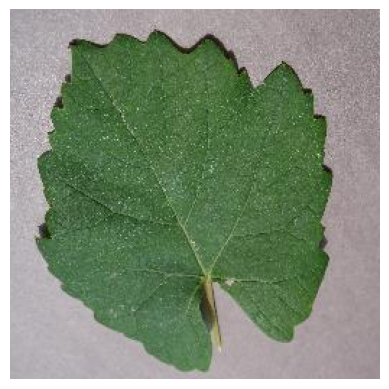

In [135]:
# Load the saved model
model = EfficientNet.from_name('efficientnet-b1', num_classes=4)
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

# Prepare the new image for input to the model
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load the new image
img = Image.open('3/image (54).jpg')

# Apply the transformation
img_tensor = transform(img).unsqueeze(0)

# Perform inference
with torch.no_grad():
    predictions = model(img_tensor)

# Get the predicted class index
predicted_class_index = torch.argmax(predictions, dim=1).item()

# Define class labels
class_labels = ["grape_black_rot", "grape_esca","grape_leaf_blight" , "grape_healthy"]

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print(f"The predicted class is: {predicted_class_label}")
plt.imshow(img)
plt.axis('off')
plt.show()
